<a href="https://colab.research.google.com/github/gulabpatel/Graph_Neural_Network/blob/main/GNN_AnomalyDetection/01_Fraud_Detection_with_Graph_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Libraries**

In [ ]:
!pip install scikit-network==0.25.0
import numpy as np
import pandas as pd
from google.colab import drive
from datetime import datetime
from datetime import timedelta
from scipy.stats.mstats import hmean
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from contextlib import contextmanager
import gc
import seaborn as sns
from sklearn.model_selection import ParameterGrid
import datetime
import time
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, precision_score, average_precision_score, recall_score
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sknetwork.utils import edgelist2adjacency, edgelist2biadjacency
from sknetwork.data import convert_edge_list, load_edge_list, load_graphml
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph
from sknetwork.clustering import Louvain, PropagationClustering, modularity, bimodularity
from IPython.display import SVG
pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings('ignore')

drive.mount('/mntDrive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 15.7 MB/s eta 0:00:00
Mounted at /mntDrive


## **Load Data from CSV Files**

In [ ]:
path = ".."
users_filename = path+'..'
fraudsters_filename = path+'..'

transactions_filename = path+'..'
parse_dates = ['CREATED_DATE']

users = pd.read_csv(users_filename, parse_dates = parse_dates)
fraudsters = pd.read_csv(fraudsters_filename)
transactions = pd.read_csv(transactions_filename, parse_dates = parse_dates)

## **Add Functions**

* **date_features(...)** - generates features from the transaction CREATED_DATE
* **draw_features(...)** - produce factor plot per every used feature, where percentage for each feature category is compared between FRAUD = 1 and FRAUD = 0
* **model_metrics(...)** - print model metrics per USER: dataset size, target percentage, target count, gini, auc, aucpr
* **model_metrics_cut(...)** - print cutoff statistics for various score cutoffs: cumulative count of objects, TP, FP, Precision, Recall, Revenue from True Positives (cumulative), Cost for Unlocking False Positives (cumulative), Cost for Checking False Positives by alert (cumulative). Extrapolates statistics to the size of the whole dataset using test/train ratio.
* **calc_profit(..)** - calculates profit for given cutoff for i = BLOCK and j = ALERT. The assumption is the following:
we select two cutoffs, one for BLOCK (i) and one for ALERT (j). We recover Revenue from TP up to smallest cutoff (j),
but we have Cost for Unlock FP up to highest cutoff (i) and Cost for Check FP between highest and smallest cutoff (i and j).
* **maximize_profit(...)** - brute-force grid search between possible cutoffs combinations (assuming BLOCK is always higher and ALERT is always smaller).
* **display_importances(...)** -  display gradient boosting feature importance statistics.


In [ ]:
def date_features(transactions):
    transactions['time_bin'] = pd.qcut((transactions['CREATED_DATE'].dt.hour * 60 + transactions['CREATED_DATE'].dt.minute) * 60 + transactions['CREATED_DATE'].dt.minute, 20, labels=range(20)).astype('int')
    transactions['hour'] = transactions['CREATED_DATE'].dt.hour
    transactions['minute'] = transactions['CREATED_DATE'].dt.minute
    transactions['week'] = transactions['CREATED_DATE'].dt.week
    transactions['weekday'] = transactions['CREATED_DATE'].dt.weekday
    transactions['dayofyear'] = transactions['CREATED_DATE'].dt.dayofyear
    transactions['dayofyear_hour_bin'] = pd.qcut((transactions['dayofyear'] * transactions['hour']).rank(method='first'), 20, labels=range(20)).astype('int')
    transactions['weekday_hour'] = transactions['weekday'] * transactions['hour']

    return transactions

def draw_features(transactions, use_features):

    for feat in use_features:
        agg = transactions.groupby(['is_fraud', feat]).agg({'ID': 'count'})
        df = agg.groupby(level=0).apply(lambda x: x / float(x.sum())).reset_index()

        plt.figure(figsize=(14, 10))
        ax = sns.factorplot(x=feat, y='ID', hue='is_fraud', data=df, kind='bar', size = 6, aspect = 2)
        ax.fig.suptitle(feat.upper()+' by is_fraud - % of transactions')
        ax.set_xticklabels(rotation=20)
        plt.show()

def model_metrics(y_v, score):
    leng = int(y_v.index.nunique() + y_t.index.nunique())
    targ_m = np.mean(y_v[y_v == 1].index.nunique() / y_v.index.nunique())
    targ_q = leng * targ_m
    gini = np.round(2*roc_auc_score(y_v, score)-1,4)
    auc =  np.round(roc_auc_score(y_v, score), 4)
    aucpr = np.round(average_precision_score(y_v, score),4)
    return pd.Series([leng, targ_m,targ_q,gini,auc,aucpr], index=['Length','Target mean', 'Targets', 'Gini', 'AUC','AUCPR'])

def model_metrics_cut(cutoff):

    pred = np.sum((score>cutoff).astype(int))
    prec = precision_score(y_v, (score>cutoff).astype(int))
    rec = recall_score(y_v, (score>cutoff).astype(int))
    corr = prec * pred
    incorr = pred - corr
    lift = prec/np.mean(y_v)
    lift = np.round(lift,4)
    prec = np.round(prec,4)
    rec = np.round(rec,4)
    extr = np.round(y_t.index.nunique()/y_v.index.nunique()+1)
    pred = np.round(pred * extr)
    corr = np.round(corr * extr)
    incorr = np.round(incorr * extr)
    rev_tp = corr * revenue_tp
    cost_ul_fp = incorr * cost_unlock_fp
    cost_ch_fp = incorr * cost_check_fp
    return pd.Series([cutoff, pred,corr, incorr, prec,rec, lift, rev_tp, cost_ul_fp, cost_ch_fp], index=['Cutoff','Predicted', 'Correct', 'Incorrect', 'Precision', 'Recall','Lift', 'Revenue_Correct', 'Cost_Unlock_Incorrect', 'Cost_Check_Incorrect'])

def calc_profit(mod_metr_cut_df, i, j):
    rev_tp = mod_metr_cut_df['Revenue_Correct'][j] - (mod_metr_cut_df['Correct'][j] - mod_metr_cut_df['Correct'][i]) * cost_check_fp
    cost_ul_fp = mod_metr_cut_df['Cost_Unlock_Incorrect'][i]
    cost_ch_fp = mod_metr_cut_df['Cost_Check_Incorrect'][j]-mod_metr_cut_df['Cost_Check_Incorrect'][i]
    profit = (rev_tp - cost_ul_fp - cost_ch_fp)
    return profit

def maximize_profit(mod_metr_cut_df, cutoff):
    max_profit = 0
    best_lock = 0
    best_check = 0

    for i in tqdm(range(len(cutoff)-1)):
      for j in range(i + 1, len(cutoff)-2):
        profit = calc_profit(mod_metr_cut_df, i, j)
        if (profit) > max_profit:
            max_profit = profit
            best_lock = i
            best_check = j
            score_lock = mod_metr_cut_df['Cutoff'][i]
            score_check = mod_metr_cut_df['Cutoff'][j]
    return max_profit, score_lock, score_check, best_lock, best_check

def display_importances_xgb(model, use_features):
    fmap = {'f'+ str(index): x for index, x in enumerate(use_features, start=0)}
    fimp_df = pd.DataFrame(list(model.get_booster().get_fscore().items()))
    fimp_df.columns = ['feature', 'importance']
    fimp_df['importance']=fimp_df['importance']/np.sum(fimp_df['importance'])
    fimp_df['feature'] = fimp_df['feature'].map(fmap)

    plt.figure(figsize=(14, 10))
    sns.barplot(x="importance", y="feature", data=fimp_df.sort_values(by="importance", ascending=False))
    plt.title('Feature Importance')
    plt.tight_layout()

## **Feature Engineering**

Generate features:

* **first_digit** - first digit of the transaction amount (according to the Benford Law)
* **last_digit** - last digit of the transaction amount (according to the intuition :))
* **user_cnt_topups** - count number of the top-ups per USER
* **user_mean_topups** - mean amount of the top-ups per USER
* **user_std_topups** - std.dev. amount of the top-ups per USER
* **user_uniq_states** - count number of unique states of transaction type = TOP-UP per USER
* **country** - frequency-encoded country with pd.factorize(...)
* **mean_time_to_tran_min** - mean time between transactions in MINUTES
* **date_features(...)** - various features based on transaction CREATED_DATE
* **louvain_community** - graph clustering of the dataset using Louvain algorithm for bipartite graphs


In [ ]:
users = users.rename({'ID':'USER_ID', 'CREATED_DATE':'USER_CREATED_DATE'}, axis='columns')
transactions = pd.merge(transactions, users, on=['USER_ID'], how='left')

transactions['is_fraud'] = transactions['USER_ID'].isin(fraudsters['USER_ID'].unique()).astype('int')

transactions['first_digit'] = transactions['AMOUNT_GBP'].astype('str').str[0].astype('int')
transactions['last_digit'] = transactions['AMOUNT_GBP'].astype('str').str[-1].astype('int')

transactions['user_cnt_topups'] = transactions['USER_ID'].map(transactions[transactions['TYPE']=='TOPUP'].groupby('USER_ID')['ID'].count())
transactions['user_mean_topups'] = pd.qcut(transactions['USER_ID'].map(transactions[transactions['TYPE']=='TOPUP'].groupby('USER_ID')['AMOUNT_GBP'].mean()), 15, labels=range(15)).astype('int')
transactions['user_std_topups'] = pd.qcut(transactions['USER_ID'].map(transactions[transactions['TYPE']=='TOPUP'].groupby('USER_ID')['AMOUNT_GBP'].std().fillna(0)), 15, labels=range(15)).astype('int')
transactions['user_uniq_states'] = transactions['USER_ID'].map(transactions[transactions['TYPE']=='TOPUP'].groupby('USER_ID')['STATE'].nunique())
transactions['country'] = pd.factorize(transactions['COUNTRY'])[0]

tmp = transactions.groupby(['USER_ID']).agg({'CREATED_DATE': [np.min, np.max], 'ID': 'count'}).reset_index()
tmp.columns = ['USER_ID', 'MIN_DATE', 'MAX_DATE', 'COUNT']
tmp['mean_time_to_tran_min'] = (np.round((((tmp['MAX_DATE']-tmp['MIN_DATE']).dt.seconds % 3600) // 60) / tmp['COUNT'])).astype('int')

transactions['mean_time_to_tran_min'] = transactions['USER_ID'].map(tmp[['USER_ID', 'mean_time_to_tran_min']].set_index('USER_ID').squeeze())
transactions = date_features(transactions)

# **Get Similar Users from User - Transaction Pairs (Bipartite Louvain)**

In [ ]:
txg = pd.melt(transactions, id_vars=['USER_ID'], value_vars=['TYPE', 'STATE', 'COUNTRY', 'CURRENCY', 'time_bin'])
txg['TOKEN'] = txg['variable'].astype(str) + "_" + txg["value"].astype(str)
txg = txg[['USER_ID', 'TOKEN']].groupby(['USER_ID', 'TOKEN']).size().reset_index()
txg.columns = ['USER_ID', 'TOKEN', 'TF']
usg = txg[['USER_ID', 'TOKEN']].groupby(['USER_ID']).size().reset_index()
usg.columns = ['USER_ID', 'IDF']
txg = txg.merge(usg, on='USER_ID')
txg['TF_IDF'] = txg['TF'] / txg['IDF']
txg = txg[['USER_ID', 'TOKEN', 'TF_IDF']]

edge_list = list(txg.itertuples(index=False))
graph = convert_edge_list(edge_list, bipartite=True)
biadjacency = graph.biadjacency
names_row = graph.names_row
names_col = graph.names_col

louvain = Louvain(resolution=1.7, modularity='newman')

louvain.fit(biadjacency)
labels_row = louvain.labels_row_
labels_col = louvain.labels_col_

bimodularity(biadjacency, labels_row, labels_col)
biadjacency_aggregate = louvain.aggregate_
labels_unique_row, counts_row = np.unique(labels_row, return_counts=True)
labels_unique_col, counts_col = np.unique(labels_col, return_counts=True)

# **Visualize Bipartite User - Transaction Communities (Bipartite Louvain)**

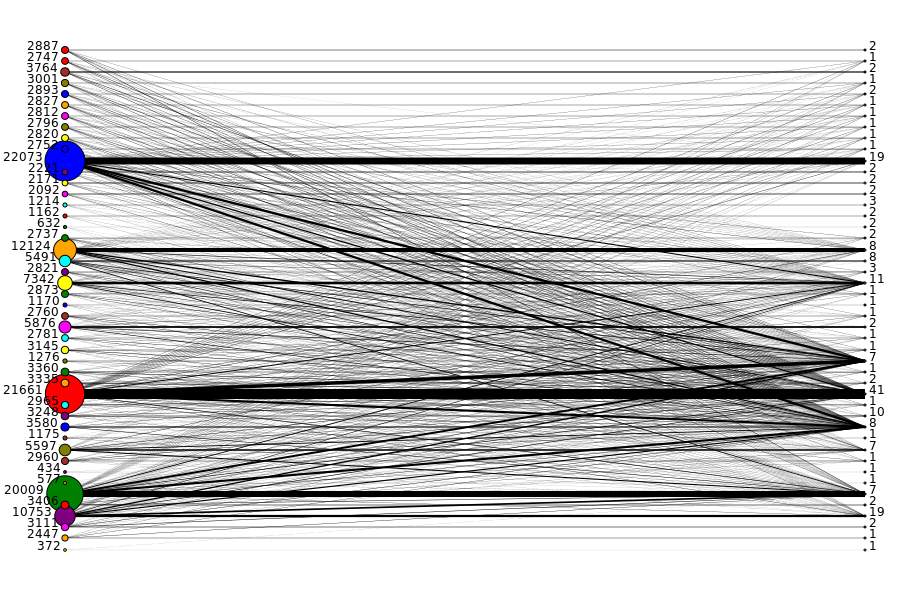

In [ ]:
image = svg_bigraph(biadjacency_aggregate, counts_row, counts_col, labels_unique_row, labels_unique_col,
                    display_node_weight=True, node_weights_row=counts_row, node_weights_col=counts_col,
                    scale=0.5, height=1000, width=1600, reorder=True, edge_width_min = 0.001, margin= 100)
SVG(image)

# **Add Louvain Community Features To Transactions**

In [ ]:
louv_dict = {}
for i, name in enumerate(names_row):
    louv_dict[name]=labels_row[i]

transactions['louvain_community'] = transactions['USER_ID'].map(louv_dict)

# **Get Similar Users from User - Transaction Pairs (Bipartite Label Propagation)**

In [ ]:
txg = pd.melt(transactions, id_vars=['USER_ID'], value_vars=['COUNTRY', 'user_cnt_topups'])
txg['TOKEN'] = txg['variable'].astype(str) + "_" + txg["value"].astype(str)
txg = txg[['USER_ID', 'TOKEN']].groupby(['USER_ID', 'TOKEN']).size().reset_index()
txg.columns = ['USER_ID', 'TOKEN', 'TF']
usg = txg[['USER_ID', 'TOKEN']].groupby(['USER_ID']).size().reset_index()
usg.columns = ['USER_ID', 'IDF']
txg = txg.merge(usg, on='USER_ID')
txg['TF_IDF'] = txg['TF'] / txg['IDF']
txg = txg[['USER_ID', 'TOKEN', 'TF_IDF']]

edge_list = list(txg.itertuples(index=False))
graph = convert_edge_list(edge_list, bipartite=True)
biadjacency = graph.biadjacency
names_row = graph.names_row
names_col = graph.names_col

labelprop = PropagationClustering(weighted=True, node_order='increasing')

labelprop.fit(biadjacency)
labels_row = labelprop.labels_row_
labels_col = labelprop.labels_col_

bimodularity(biadjacency, labels_row, labels_col)
biadjacency_aggregate = labelprop.aggregate_
labels_unique_row, counts_row = np.unique(labels_row, return_counts=True)
labels_unique_col, counts_col = np.unique(labels_col, return_counts=True)

# **Visualize Bipartite User - Transaction Communities (Bipartite Label Propagation)**

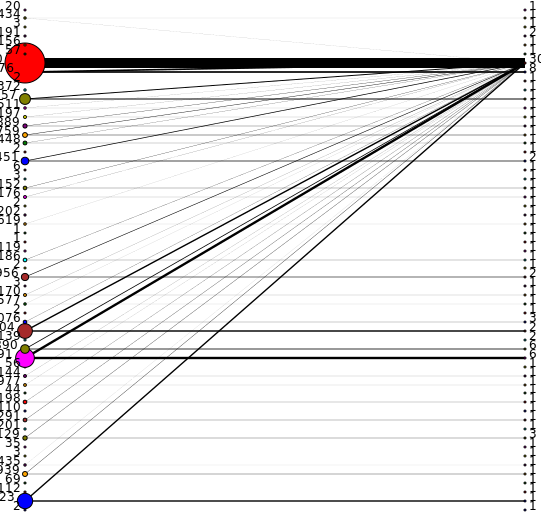

In [ ]:
image = svg_bigraph(biadjacency_aggregate, counts_row, counts_col, labels_unique_row, labels_unique_col,
                    display_node_weight=True, node_weights_row=counts_row, node_weights_col=counts_col,
                    scale=0.5, height=1000, width=1000, reorder=True, edge_width_min = 0.01)
SVG(image)

# **Add Label Propagation Community Features To Transactions**

In [ ]:
lprop_dict = {}
for i, name in enumerate(names_row):
    lprop_dict[name]=labels_row[i]

transactions['labelprop_community'] = transactions['USER_ID'].map(lprop_dict)

## **Exploration Data Analysis**

We explore added features for high discrepancy between categories percentage.
We plot every variable as factor plot where ORANGE = FRAUD, BLUE = NO FRAUD, and we see percentage of each category occurences in both (FRAUD and NO FRAUD) parts of the datasets.

When we see a lot of differences in percentage between categories of some variable for FRAUD and NO FRAUD, we consider this feature and include in our further analysis.

<Figure size 1008x720 with 0 Axes>

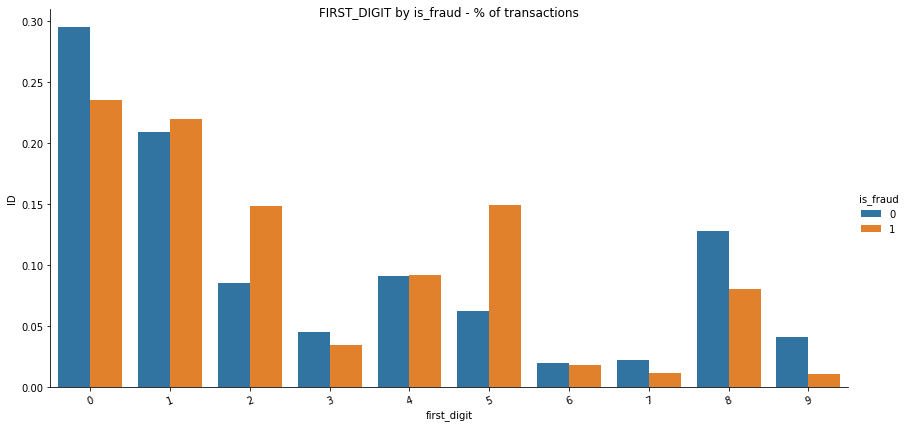

<Figure size 1008x720 with 0 Axes>

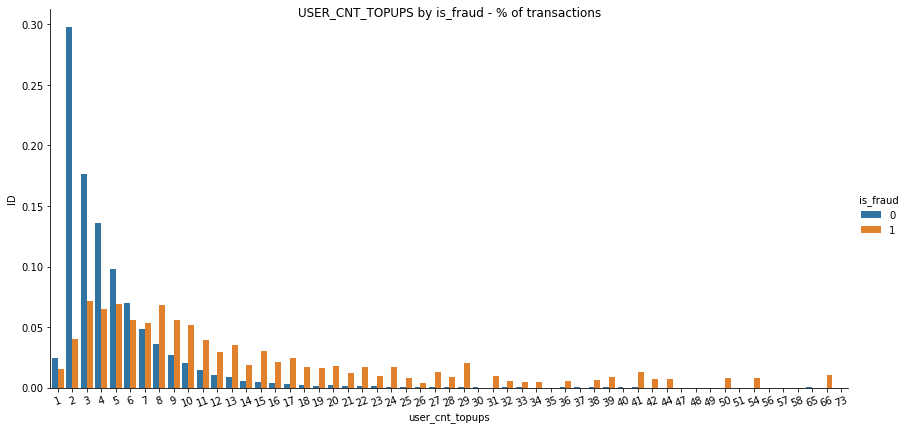

<Figure size 1008x720 with 0 Axes>

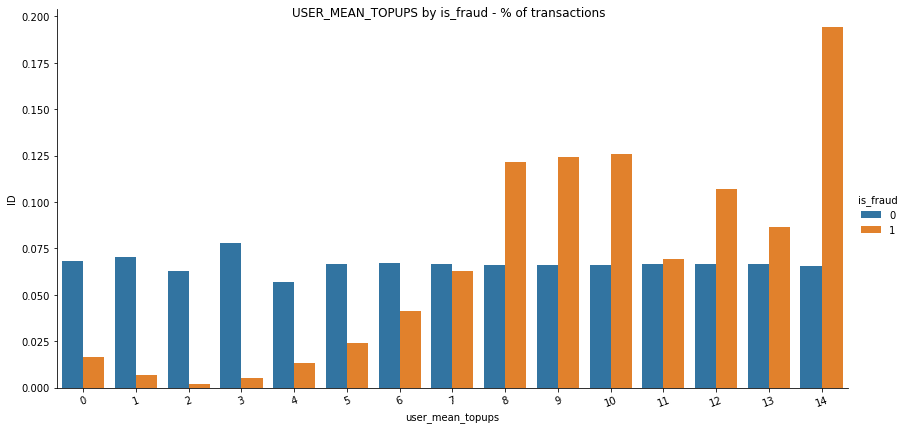

<Figure size 1008x720 with 0 Axes>

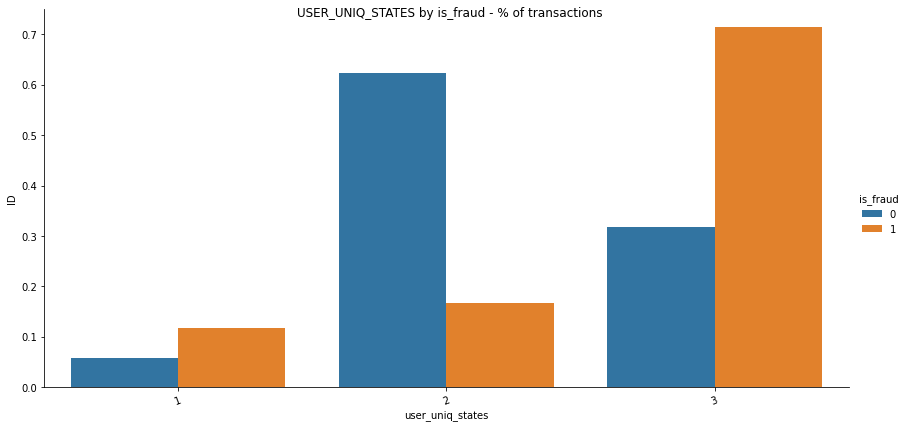

<Figure size 1008x720 with 0 Axes>

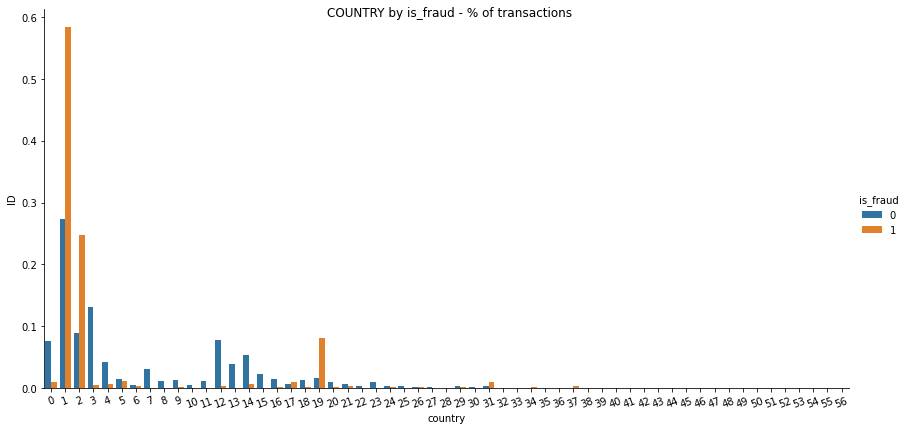

<Figure size 1008x720 with 0 Axes>

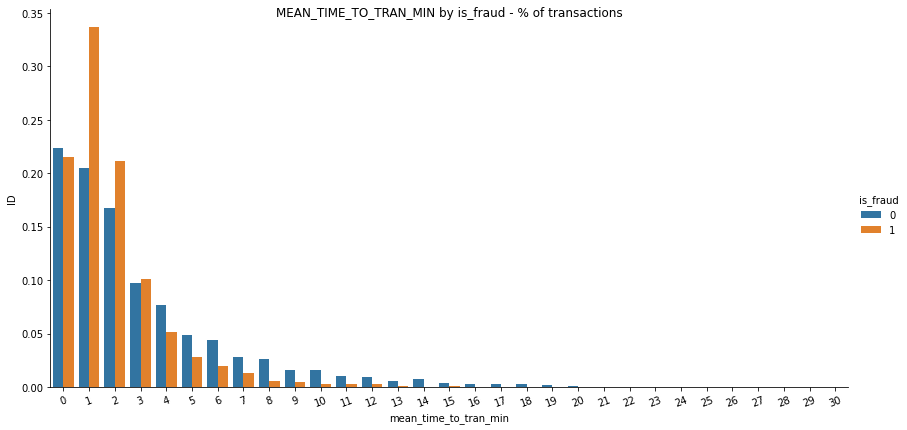

<Figure size 1008x720 with 0 Axes>

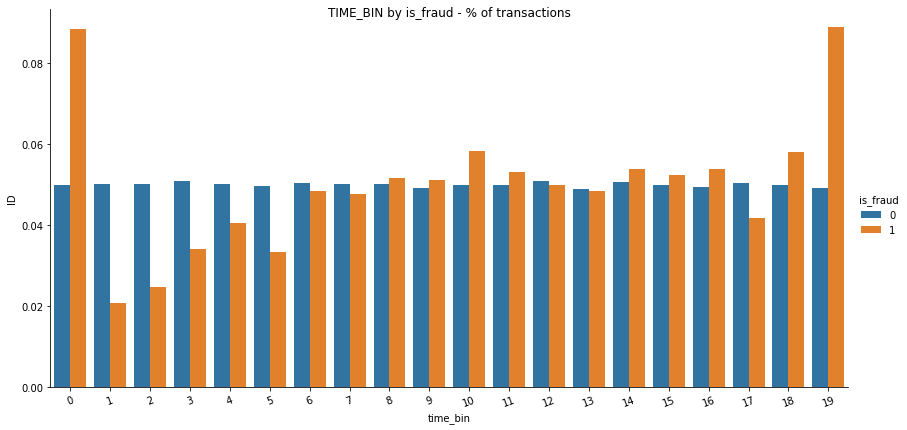

<Figure size 1008x720 with 0 Axes>

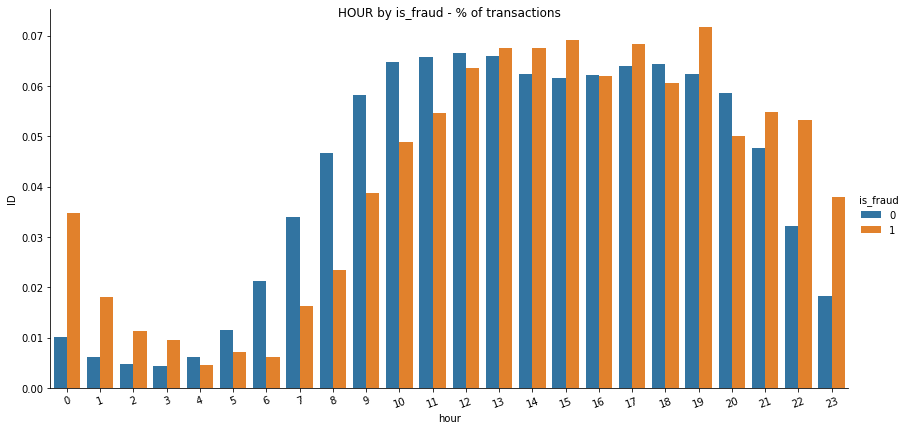

<Figure size 1008x720 with 0 Axes>

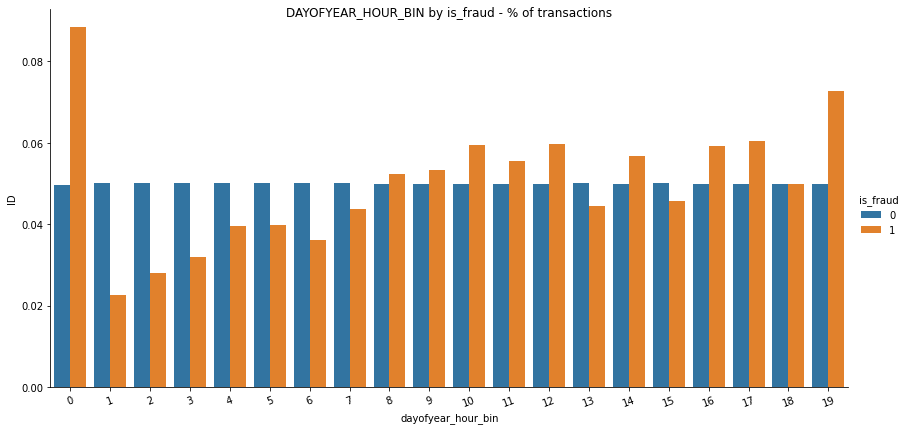

<Figure size 1008x720 with 0 Axes>

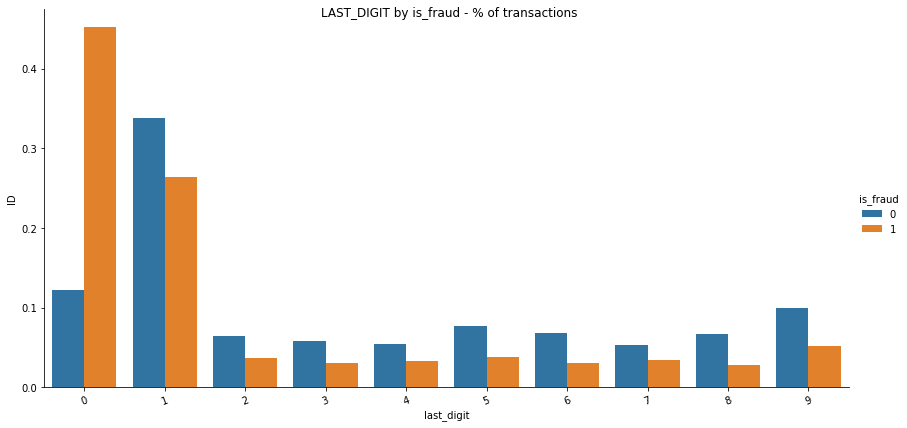

<Figure size 1008x720 with 0 Axes>

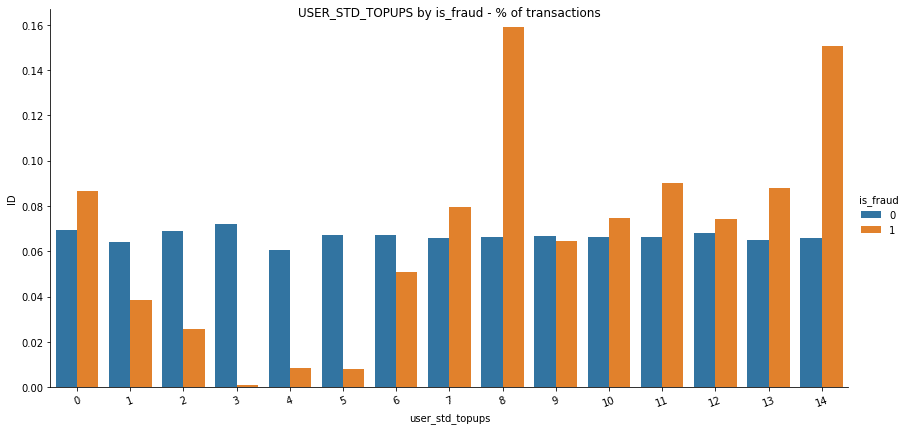

<Figure size 1008x720 with 0 Axes>

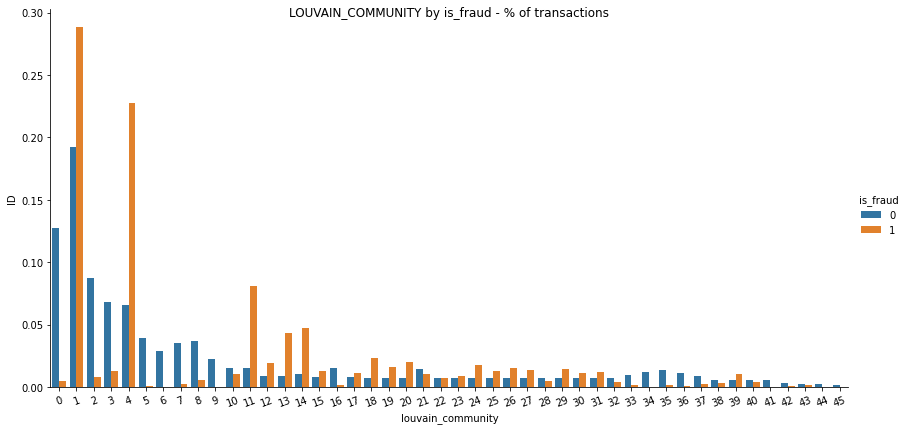

<Figure size 1008x720 with 0 Axes>

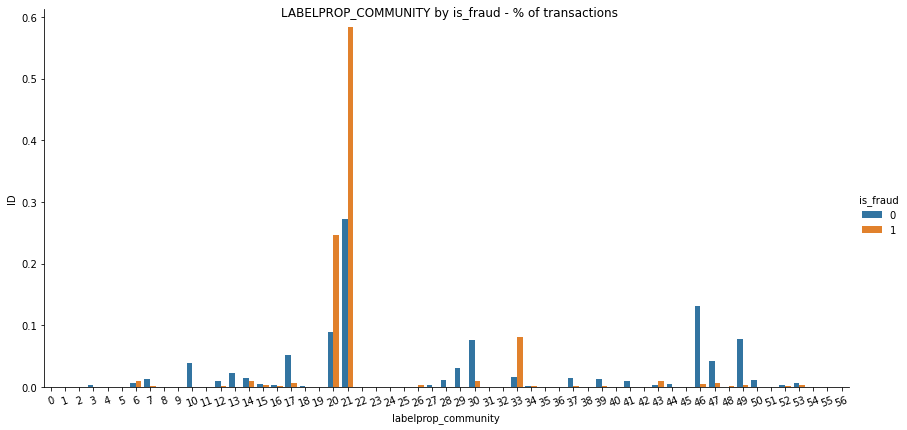

In [ ]:
use_features_graph = ['first_digit', 'user_cnt_topups', 'user_mean_topups', 'user_uniq_states', 'country', 'mean_time_to_tran_min',
                 'time_bin', 'hour', 'dayofyear_hour_bin', 'last_digit', 'user_std_topups', 'louvain_community', 'labelprop_community']

use_features_no_graph = ['first_digit', 'user_cnt_topups', 'user_mean_topups', 'user_uniq_states', 'country', 'mean_time_to_tran_min',
                 'time_bin', 'hour', 'dayofyear_hour_bin', 'last_digit', 'user_std_topups']

draw_features(transactions, use_features_graph)

## **Train-Test Split**

We split for train and test using USER_ID as group for splitting: we would like to have only unseen user transactions in test part of dataset. We fix random seed as well to make our splitting reproducible.

In [ ]:
from sklearn.model_selection import GroupShuffleSplit, train_test_split
transactions = transactions.set_index('USER_ID')
X = transactions[use_features_graph]
y = transactions['is_fraud']
groups = transactions.index

np.random.seed(40)
train_inds, test_inds = next(GroupShuffleSplit(test_size=0.33).split(X, y, groups=groups))
X_t, X_v, y_t, y_v = X.iloc[train_inds], X.iloc[test_inds], y[train_inds], y[test_inds]

## **Check Target Statistics**

We check target statistics - looks pretty similiar! Cool! Let's train some model.

In [ ]:
##Check target statistics
print('Train target:', np.sum(y_t)/len(y_t))
print('Test target:', np.sum(y_v)/len(y_v))

Train target: 0.007656705331123936
Test target: 0.007776067499002337


## **Model Training**

In [ ]:
xgb_clf = XGBClassifier(nthread=-1, n_estimators=100, learning_rate=0.1, objective='binary:logistic',
                        max_depth=2, scale_pos_weight=400, min_child_weight=80, gamma = 10, max_delta_step=2)

X_t = check_array(X_t)
xgb_clf.fit(X_t, y_t)

XGBClassifier(gamma=10, max_delta_step=2, max_depth=2, min_child_weight=80,
              nthread=-1, scale_pos_weight=400)

## **Feature Importances**

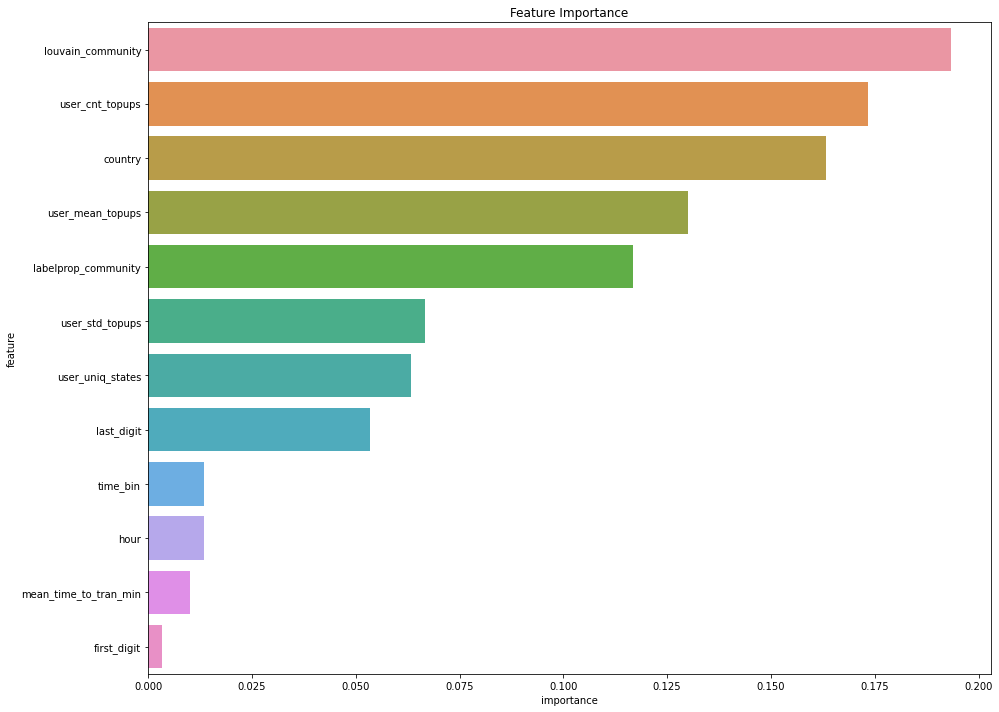

In [ ]:
display_importances_xgb(xgb_clf, use_features_graph)

## **Calculate Revenue for True Positive**

We calculate revenue per user which we can recover if we will have true positive - correctly predicted unseen (!) fraud.
We just approximate the amount (or make and assumption) that average money turnover per fraud USER is good candidate for it.

In [ ]:
fraud_volume = np.sum(transactions[transactions['is_fraud']==1]['AMOUNT_GBP'])
uniq_users = transactions[transactions['is_fraud']==1].index.nunique()
revenue_tp = fraud_volume/uniq_users
print('Revenue TP per USER:', revenue_tp)

Revenue TP per USER: 1000.2699207397621


## **Calculate Unlock and Check Costs for False Positive**

We assume the average salary of bank clerk as 40000 euro annually, 12 months in year, 160 hours in months and:
* 4 days, or 32 working hours to unlock incorrectly locked USER
* 1 day, or 8 working hours to check all the transactions of alerted USER

In [ ]:
# Clerk Salary = 40000 euro, days_to_unlock = 4
cost_unlock_fp = 40000/12/160*32
print('Cost unlock for FP per USER:', cost_unlock_fp)
# Clerk Salary = 40000 euro, days_to_check = 1
cost_check_fp = 40000/12/160*8
print('Cost check for FP per USER:', cost_check_fp)

Cost unlock for FP per USER: 666.6666666666667
Cost check for FP per USER: 166.66666666666669


## **Calculate Model Metrics on USER level**

Here we calculate the output of just two initially described functions (on USER level):

* **model_metrics(...)** - print model metrics per USER: dataset size, target percentage, target count, gini, auc, aucpr
* **model_metrics_cut(...)** - print cutoff statistics for various score cutoffs: cumulative count of objects, TP, FP, Precision, Recall, Revenue from True Positives (cumulative), Cost for Unlocking False Positives (cumulative), Cost for Checking False Positives by alert (cumulative). Extrapolates statistics to the size of the whole dataset using test/train ratio.

In [ ]:
X_vc = X_v.copy()
X_vc['score'] = xgb_clf.predict_proba(X_vc.values)[:,1]
y_v = y_v.groupby('USER_ID').mean()
score = X_vc.groupby('USER_ID')['score'].mean()

q = 0.98
cutoff = np.round(np.linspace(0,1,100)[::-1],2)
cutoff = pd.DataFrame(cutoff)*q
cutoff.columns = ['Cutoff']

print('Model metrics:')
mod_metr_df = model_metrics(y_v, score)
print(mod_metr_df)
mod_metr_cut_df = cutoff['Cutoff'].apply(model_metrics_cut)

Model metrics:
Length        200250.00
Target mean        0.00
Targets          757.57
Gini               0.91
AUC                0.95
AUCPR              0.26
dtype: float64


## **Show Cutoff Statistics**

In [ ]:
mod_metr_cut_df.head(30)

,Cutoff,Predicted,Correct,Incorrect,Precision,Recall,Lift,Revenue_Correct,Cost_Unlock_Incorrect,Cost_Check_Incorrect
0,0.98,105.00,45.00,60.00,0.43,0.06,113.29,45012.15,40000.00,10000.00
1,0.97,264.00,117.00,147.00,0.44,0.16,117.15,117031.58,98000.00,24500.00
2,0.96,546.00,237.00,309.00,0.43,0.32,114.74,237063.97,206000.00,51500.00
3,0.95,738.00,285.00,453.00,0.39,0.38,102.08,285076.93,302000.00,75500.00
4,0.94,987.00,336.00,651.00,0.34,0.45,89.99,336090.69,434000.00,108500.00
5,0.93,1254.00,366.00,888.00,0.29,0.49,77.15,366098.79,592000.00,148000.00
6,0.92,1587.00,393.00,1194.00,0.25,0.52,65.46,393106.08,796000.00,199000.00
7,0.91,1920.00,417.00,1503.00,0.22,0.56,57.41,417112.56,1002000.00,250500.00
8,0.90,2244.00,447.00,1797.00,0.20,0.60,52.65,447120.65,1198000.00,299500.00
9,0.89,2565.00,459.00,2106.00,0.18,0.61,47.30,459123.89,1404000.00,351000.00


## **Visualize Cutoff Selection Graphically (Separately)**

We visualize it here with two separate plots - with Lock profit and with Check profit.

* Optimal cutoff for BLOCK decision separately is 0.95
* Optimal cutoff for ALERT decision separately is 0.91

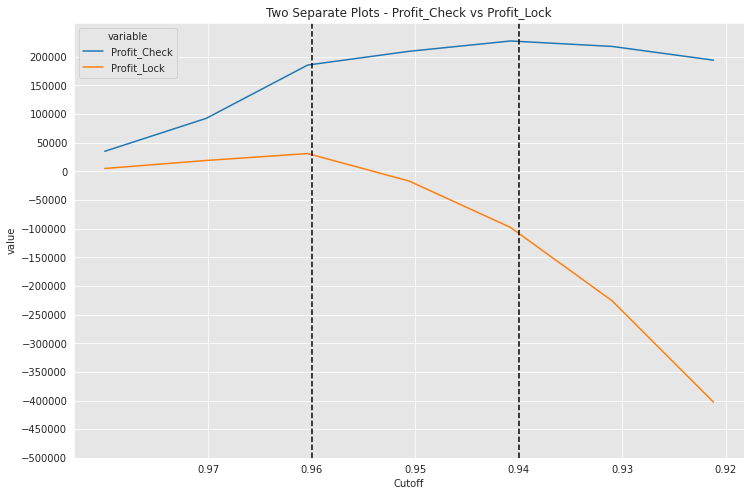

In [ ]:
effect = mod_metr_cut_df[['Cutoff', 'Revenue_Correct', 'Cost_Unlock_Incorrect', 'Cost_Check_Incorrect', 'Incorrect']]
effect['Profit_Check']=(effect['Revenue_Correct']-effect['Cost_Check_Incorrect'])
effect['Profit_Lock']=(effect['Revenue_Correct']-effect['Cost_Unlock_Incorrect'])
data = pd.melt(effect[['Cutoff', 'Profit_Check', 'Profit_Lock']][effect['Cutoff']>0.92], ['Cutoff'])

plt.figure(figsize=(12,8))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
ax = sns.lineplot(x='Cutoff', y='value', hue='variable',
             data=data)
ax.invert_xaxis()
ax.set_title('Two Separate Plots - Profit_Check vs Profit_Lock')
ax.set_yticks(np.arange(-500000,250000,50000))
ax.set_xticks(np.arange(0.92,0.98,0.01))
xposition = [0.96, 0.94]
for xc in xposition:
    plt.axvline(x=xc, color='k', linestyle='--')

## **Maximize Profit (Jointly)**

Here we run the following function:

**maximize_profit(...)** - brute-force grid search between possible cutoffs combinations (assuming BLOCK is always higher and ALERT is always smaller).

This function optimize cutoff selection jointly. Greater than largest cutoff, 0.98, everybody is blocked.
Between both cutoffs, 0.98 and 0.91, everybody is checked. Ideally, we have to make this task constrained optimization,
because resources of bank clerks for checking transactions and users are limited anyway. But we will keep it simple for now.

In [ ]:
max_profit, score_lock, score_check, best_lock, best_check = maximize_profit(mod_metr_cut_df, cutoff)

print('')
i = 0
j = 3
print('Maximum profit per MONTH (EURO):', np.round(max_profit, 2))
print('Number of USERs to check:', mod_metr_cut_df['Predicted'][j]-mod_metr_cut_df['Predicted'][i])
print('Number of Bank Clerks required per MONTH:', np.round((mod_metr_cut_df['Predicted'][j]-mod_metr_cut_df['Predicted'][i])*8/160))
print('Score to lock:', np.round(score_lock, 2))
print('Score to check:', np.round(score_check, 2))
print('')
i = 2
j = 3
print('Profit (EURO) for visual thresholds:', np.round(calc_profit(mod_metr_cut_df, i,j), 2))
print('Number of USERs to check:', mod_metr_cut_df['Predicted'][j]-mod_metr_cut_df['Predicted'][i])
print('Number of Bank Clerks required per MONTH:', np.round((mod_metr_cut_df['Predicted'][j]-mod_metr_cut_df['Predicted'][i])*8/160))
print('Score to lock:', np.round(mod_metr_cut_df['Cutoff'][i], 2))
print('Score to check:', np.round(mod_metr_cut_df['Cutoff'][j], 2))


100%|██████████| 99/99 [00:00<00:00, 556.37it/s]


Maximum profit per MONTH (EURO): 149090.69
Number of USERs to check: 633.0
Number of Bank Clerks required per MONTH: 32.0
Score to lock: 0.98
Score to check: 0.94

Profit (EURO) for visual thresholds: 47076.93
Number of USERs to check: 192.0
Number of Bank Clerks required per MONTH: 10.0
Score to lock: 0.96
Score to check: 0.95
